<!--NAVIGATION-->
< [Request All Intraday Data](For_The_Bit_01-02_Request_All_Intraday_Data.ipynb) | [Contents](For_The_Bit_00-Introduction.ipynb) | [Get Exercise Logs](For_The_Bit_01-04_Get_Exercise_Logs.ipynb) >

# For The Bit

## 1 - Getting my `fitbit` data 
### Part III. Extract, transform, and merge local intraday json files into a Python `pandas` time series DataFrame

Rather than silo'ed in their individual json files, let's merge everything into a minute-by-minute dataFrame.

We want to programatically combine all the data into a single minute-by-minute DataFrame, something like this:

|date|steps|HR| sleep|
|---|---|---|---|
|2017-01-23 00:03| 17 | 68 | NaN |
|2017-01-23 00:04| 1 | 67 | 2 |
|2017-01-23 00:05| 0 | 66 | 1 |

We'll do this since the first minute I had my Charge 2, forcing missing data to have `NaN` values.

To do this right we'd also need some more info/columns:  
- Time Zone
- Activity class  

Let's ignore those for now.

In [1]:
import json
import pandas as pd
import os.path
import time

Construct a list of the dates I want.  I got my Charge 2 on: `2016-12-17`

In [2]:
today = time.strftime("%Y-%m-%d")
minute_ids = pd.date_range(start='20161217', end=today, freq='1Min')
date_ids = pd.date_range(start='20161217', end=today, freq='D')
date_strs = date_ids.strftime("%Y-%m-%d")

In [3]:
len(minute_ids), len(date_ids)

(195841, 137)

As you can see, this is a ~100k+ point times series spanning ~100+ days.  wow!

<h3 style="text-align: center;" markdown="1">What we want for the *Steps* `DataFrame`:</h3>

|date|steps|
|---|---|
|2017-01-23 00:03| 17 |
|2017-01-23 00:04| 1 |
|2017-01-23 00:05| 0 |



In [4]:
steps_df = pd.DataFrame()
for i, date in enumerate(date_strs[:-1]):
    local_file = 'steps_'+date+'_1d_1min.json'
    full_path = '../data/gully/intraday/steps/'+local_file
    # Only make a query if we don't already have the file.
    try: 
        with open(full_path, 'r') as f:
            json_data = json.load(f)
        temp_df = pd.DataFrame(json_data['activities-steps-intraday']['dataset'])
        temp_df = temp_df.set_index(pd.DatetimeIndex(date + ' ' + temp_df['time']))
        steps_df = steps_df.append(temp_df)
    except:
        print('{} {} Did not work'.format(i, date))

There's probably a faster way to do this, but it's fast enough.

In [5]:
steps_df = steps_df.rename(columns={'value':'steps'})
del steps_df['time']

In [6]:
steps_df.head(3)

,steps
2016-12-17 00:00:00,0
2016-12-17 00:01:00,0
2016-12-17 00:02:00,0


It works!

<h3 style="text-align: center;" markdown="1">What we want for the *HR* `DataFrame`:</h3>

|date|HR|
|---|---|
|2017-01-23 00:03| 68 |
|2017-01-23 00:04| 67 |
|2017-01-23 00:05| 66 |

In [7]:
HR_df = pd.DataFrame()
for i, date in enumerate(date_strs[:-1]):
    local_file = 'HR_'+date+'_1d_1min.json'
    full_path = '../data/gully/intraday/HR/'+local_file
    # Only make a query if we don't already have the file.
    try: 
        with open(full_path, 'r') as f:
            json_data = json.load(f)
        temp_df = pd.DataFrame(json_data['activities-heart-intraday']['dataset'])
        temp_df = temp_df.set_index(pd.DatetimeIndex(date + ' ' + temp_df['time']))
        HR_df = HR_df.append(temp_df)
    except:
        print('{} {} Did not work'.format(i, date))

In [8]:
del HR_df['time']
HR_df = HR_df.rename(columns={'value':'HR'})

In [9]:
HR_df.head(3)

,HR
2016-12-17 20:24:00,63
2016-12-17 20:25:00,70
2016-12-17 20:26:00,66


### And similarly for sleep:

In [10]:
import datetime

In [11]:
#keys = json_data['sleep'][0].keys()
#subset_keys = sorted(list(set(keys) - set(['minuteData'])))
#for i, key in enumerate(subset_keys):
#    print('{:<30}: {}'.format(key,json_data['sleep'][0][key]))

In [12]:
sleep_df = pd.DataFrame()
for i, date in enumerate(date_strs[1:-1]):
    local_file = 'sleep_'+date+'_1d_1min.json'
    full_path = '../data/gully/intraday/sleep/'+local_file
    try: 
        with open(full_path, 'r') as f:
            json_data = json.load(f)
        temp_df = pd.DataFrame(json_data['sleep'][0]['minuteData']) # Ignore naps for now.
        #print(i, len(json_data['sleep']))
        # For some reason fitbit uses 30-second intervals sometimes! WTF!
        start = pd.to_datetime(json_data['sleep'][0]['startTime'][:-7]) #Round down to nearest minute
        min_asleep = json_data['sleep'][0]['timeInBed'] -1
        end = start + datetime.timedelta(minutes=min_asleep)
        sleep_times = pd.date_range(start=start, end=end, freq='1Min')
        temp_df['time'] = sleep_times
        temp_df = temp_df.set_index('time')
        sleep_df = sleep_df.append(temp_df)
        #print(start.strftime('%H:%M:%S'), temp_df.dateTime[0], len(sleep_times)-len(temp_df.value))
        #print(len(sleep_times), len(temp_df.value))
    except (ValueError, IndexError, FileNotFoundError) as e:
        print('{} {} Did not work'.format(i, date))

97 2017-03-25 Did not work


In [13]:
! head ../data/gully/intraday/sleep/sleep_2017-03-25_1d_1min.json

{"sleep": [], "summary": {"totalTimeInBed": 0, "totalMinutesAsleep": 0, "totalSleepRecords": 0}}

I didn't wear my `fitbit` Charge 2 on March 25, 2017.  Not bad-- I've worn it every other day!

In [14]:
sleep_df['sleep'] = sleep_df.value.astype(np.int)
del sleep_df['dateTime']
del sleep_df['value']
sleep_df.head()

,sleep
time,
2016-12-18 00:25:00,1
2016-12-18 00:26:00,1
2016-12-18 00:27:00,2
2016-12-18 00:28:00,2
2016-12-18 00:29:00,2


## Merge

In [15]:
steps_and_HR = pd.merge(steps_df, HR_df, left_index=True, right_index=True)

In [16]:
mgs = pd.merge(steps_and_HR, sleep_df, left_index=True, right_index=True, how='outer')

In [17]:
mgs.to_csv('../data/gully/intraday/mgs_intraday.csv')

In [18]:
!du -hs ../data/gully/intraday/mgs_intraday.csv

5.3M	../data/gully/intraday/mgs_intraday.csv


5.0 MB of csv file.

## First look analysis

In [19]:
len(set(minute_ids) -set(mgs.index))/len(set(minute_ids))

0.08504347914890141

8% of the data is missing.  Does that mean I wear my Charge 2 at least 92% of the time?

In [20]:
len(set(sleep_df.index))/len(set(minute_ids))

0.32901690657216826

I apparently sleep 32.9% of the time.

In [21]:
mgs.tail()

,steps,HR,sleep
2017-05-01 23:55:00,0.0,63.0,NaN
2017-05-01 23:56:00,0.0,63.0,NaN
2017-05-01 23:57:00,0.0,64.0,NaN
2017-05-01 23:58:00,0.0,64.0,NaN
2017-05-01 23:59:00,0.0,63.0,NaN


In [22]:
mgs.sleep.unique()

array([ nan,   1.,   2.,   3.])

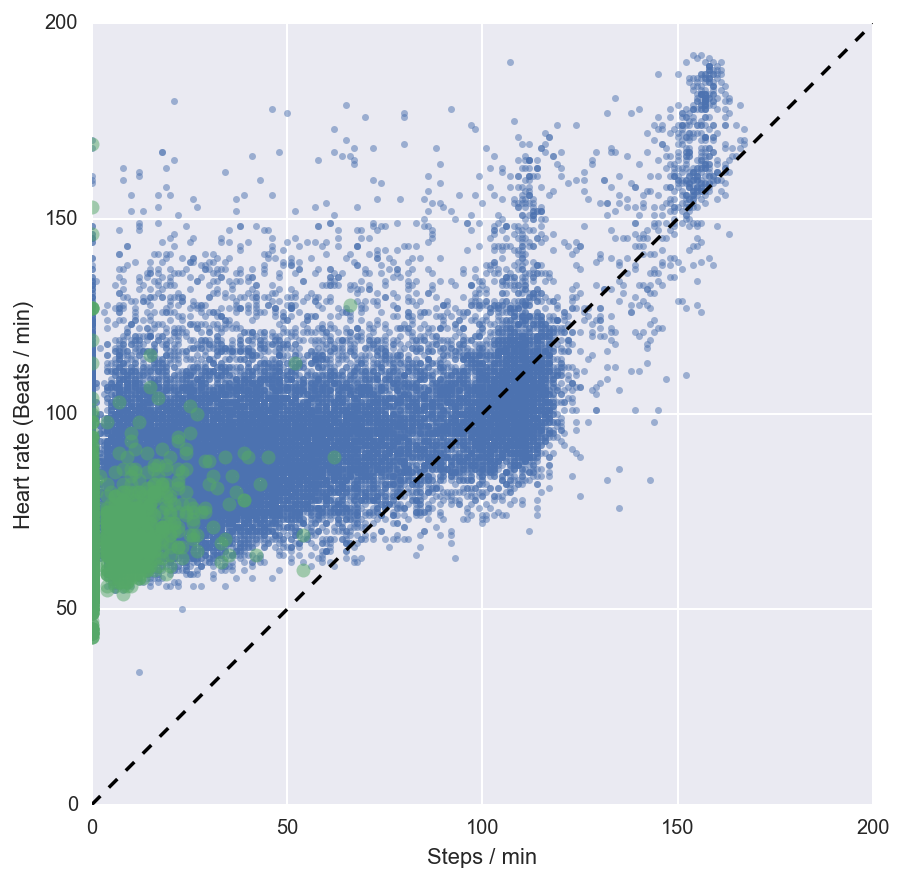

In [23]:
plt.figure(figsize=(7, 7))
sleeping = mgs.sleep == mgs.sleep
awake = mgs.sleep != mgs.sleep
moving = mgs.steps > 5
plt.plot(mgs.steps[awake], mgs.HR[awake], '.', alpha=0.5)
plt.plot(mgs.steps[sleeping], mgs.HR[sleeping], 'o', alpha=0.5)
plt.plot([0,200], [0,200], 'k--')
plt.xlabel('Steps / min')
plt.ylabel('Heart rate (Beats / min)')
plt.xlim(0, 200);

Neat stuff!  More to come.